# PhD Meeting Data Analysis 
This notebook presents analysis of PhD meeting dataset collected from meetings regularily held in Tallinn University between supervisors and PhD students.


The analyzed dataset is collected 20th August 2021 using CoTrack tool.

## Voice Activity Detection Analysis
To check the performance of voice activity detection using Python library, I annotated first 20 minutes of audio of PhD student who reported the PhD progress during the meeting.

The annotation was done using Praat tool. The following script transform the Praat annotations into format that can be analyzed using pyannote library.

In [61]:
from pyannote.core import Annotation, Segment, Timeline, notebook
from pyannote.metrics import detection
import matplotlib.pyplot as plt
from itertools import combinations
import datetime
import pandas as pd
import collections
import contextlib
import sys
import wave
import networkx as nx
import webrtcvad

In [4]:
"""
This code reads Praat annotation file and load it as a Pandas DataFrame.
"""
def trim_white_newline(string):
    new_list = list()
    for item in string:
        if item == '' or item == '\n':
            pass
        else:
            new_list.append(item)
    return new_list

# Open Praat Transcribe File
f = open('11_1_172_Final_file_1628860913000_IND_Audio.TextGrid')

# Read lines from the file
lines = f.readlines()

# Create a empty dataframe for storing transcribe data
df = pd.DataFrame(columns = ["start","end","user"])


line_count = 0
read_flag = False

# Iterate over all lines one by one
for line in lines:
    #print('processing:',line)
    # read flag is true. This flag specify that the next line is the data line.
    if read_flag == True:

        # Increase line count
        line_count = line_count + 1

        # Condition to read only three lines. Each data transciption has three lines.
        if line_count < 4:
            # Split the line using space.
            words = line.split(" ")

            # Remove white spaces
            words = trim_white_newline(words)

            # First token as start time of the frame
            if line_count == 1:
                start = float(words[2])
            # Second token as end time of the frame
            if line_count == 2:
                end = float(words[2])
            # third token as annotatation
            if line_count == 3:
                user = words[2].strip()
                user = user.replace('"','')
                line_count=0
                read_flag = False
                #print('  added')
                # Append data to dataframe
                df = df.append({'start':start,'end':end,'user':user},ignore_index = True)

    # Condition to check if current line has 'intervals [' string
    elif line.find('intervals [')==-1:
        pass
    else:
        read_flag = True

# Computer annotated window time
df["speaking"] = df["end"] - df["start"]

df.drop(df.tail(1).index,inplace=True)
# Save to csv format.
df.to_csv('annotated.csv') 

In [6]:
ground_truth = df.copy()

# extract speach regions only
speak_gd = ground_truth.loc[ground_truth.user=='1',:]
speak_gd.head()

,start,end,user,speaking
5,18.074814,18.801147,1,0.726334
7,19.479059,20.253815,1,0.774756
9,31.302242,32.176249,1,0.874007
15,53.538445,54.058125,1,0.519680
23,65.697326,66.240628,1,0.543302


## Analyzing VAD using python's library
The VAD data which were obtained from CoTrack tool had some issues. It was observed that during the data recording session, on one of the participant's system, the tool was continously detecting voice activity wrongly. Therefore, for analysis purposes, another library was used to extract VAD data from audios and the accuracy was measured.

In [9]:
def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.

    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.

    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.

    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.

    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.

    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.

    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.

    Arguments:

    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).

    Returns: A generator that yields PCM audio data.
    """
    # Create a empty dataframe for storing transcribe data
    vad_df = pd.DataFrame(columns = ["start","end","user"])
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        #sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start = ring_buffer[0][0].timestamp
                #sys.stdout.write('Timestamp:(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                end = ring_buffer[0][0].timestamp
                #sys.stdout.write('End:(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                #yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                vad_df = vad_df.append({'start':start,'end':end,'user':user},ignore_index = True)
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    #sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    return vad_df



vad = webrtcvad.Vad(3)   
audio, sample_rate = read_wave('./11_1_172_Final_file_1628860913000_IND_Audio.wav')

frames = frame_generator(30, audio, sample_rate)
frames = list(frames)
segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [10]:
# Shashi audio vad analysis
shashi_audio,sample_rate = read_wave('./11_1_172_Final_file_1628860913000_IND_Audio.wav')
frames = frame_generator(30, shashi_audio, sample_rate)
frames = list(frames)
shashi_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [11]:
# Pankaj audio vad analysis
pankaj_audio,sample_rate = read_wave('./11_1_1_Final_file_1628859941379_IND_Audio.wav')
frames = frame_generator(30, pankaj_audio, sample_rate)
frames = list(frames)
pankaj_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [12]:
# Luis audio vad analysis
luis_audio,sample_rate = read_wave('./11_1_153_Final_file_1628860913138_IND_Audio.wav')
frames = frame_generator(30, luis_audio, sample_rate)
frames = list(frames)
luis_segments = vad_collector(sample_rate, 20, 300, vad, frames)

In [13]:
# Chus audio vad analysis
chus_audio,sample_rate = read_wave('./11_1_155_Final_file_1628859613760_IND_Audio.wav')
frames = frame_generator(30, chus_audio, sample_rate)
frames = list(frames)
chus_segments = vad_collector(sample_rate, 20, 300, vad, frames)

### Performance evaluation of VAD method


In [14]:
# Extract first 20 minutes of VAD data for comparision with ground-truth
vad_segments= segments.loc[segments.start < 1676,:]

In [16]:
# To evalute, we used PyAnnote library

# Create annotation generated by VAD library
vad_seg_an = Annotation()
for i in range(vad_segments.shape[0]):
    record = vad_segments.loc[i,:]
    vad_seg_an[Segment(record['start'], record['end']), '_'] = 'pyvad'

# Create annotation of ground-truth
gd_an = Annotation()
speak_gd.reset_index(inplace=True)
for i in range(speak_gd.shape[0]):
    record = speak_gd.loc[i,:]
    gd_an[Segment(record['start'], record['end']), '_'] = 'gd'

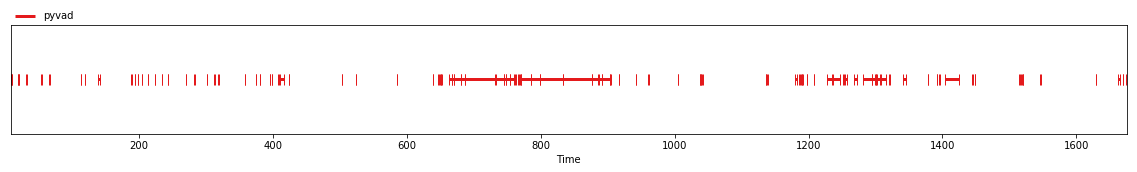

In [17]:
vad_seg_an

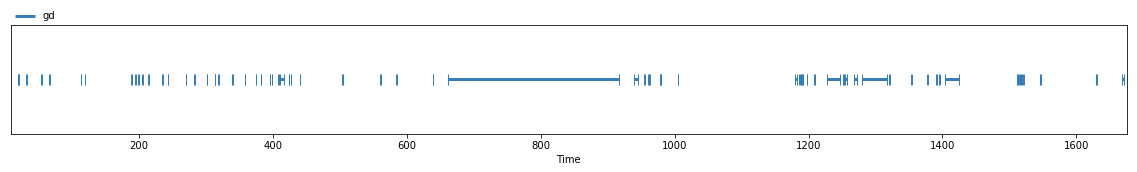

In [18]:
gd_an

In [20]:
# Computing accuracy, error rate and cost function
det_acc = detection.DetectionAccuracy()
det_err = detection.DetectionErrorRate()
det_cf = detection.DetectionCostFunction()

In [21]:
print('Detection accuracy:',det_acc.compute_metric(det_acc.compute_components(vad_seg_an,gd_an)))
print('Detection error rate:',det_err.compute_metric(det_err.compute_components(vad_seg_an,gd_an)))
print('Detection cost function:',det_cf.compute_metric(det_cf.compute_components(vad_seg_an,gd_an)))

Detection accuracy: 0.9443070805453685
Detection error rate: 0.25243702478729363
Detection cost function: 0.061424020959540235


/Users/pankaj/opt/anaconda3/lib/python3.8/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


The detection accuracy was found to be 94%. 

## Analysis of VAD for all participants

In [22]:
all_an = Annotation()
for i in range(shashi_segments.shape[0]):
    record = shashi_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '1'] = 'shashi'
for i in range(luis_segments.shape[0]):
    record = luis_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '2'] = 'luis'
for i in range(pankaj_segments.shape[0]):
    record = pankaj_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '3'] = 'pankaj'
for i in range(chus_segments.shape[0]):
    record = chus_segments.loc[i,:]
    all_an[Segment(record['start'], record['end']), '4'] = 'chus'

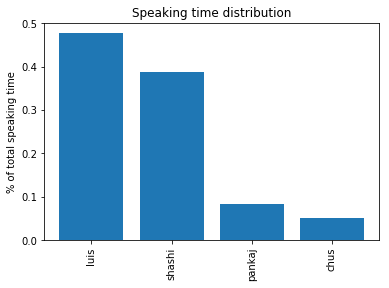

In [24]:
chart = all_an.chart(percent=True)
x = [i for i in range(len(chart))]
labels = [i[0] for i in chart]
plt.bar(x,[i[1] for i in chart])
plt.xticks(x, labels, rotation='vertical')
plt.ylabel('% of total speaking time')
plt.title('Speaking time distribution')
plt.show()

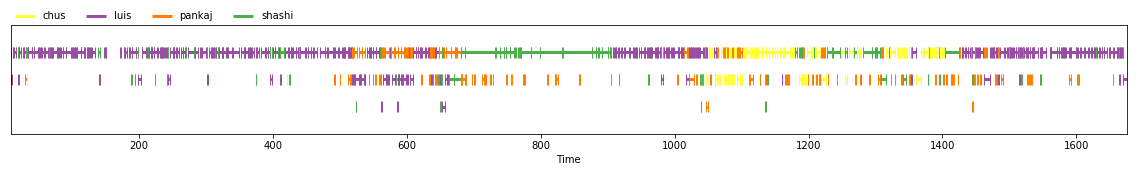

In [25]:
# Plotting speaking sequence for all the participants
all_an

In above figure, voice activity for pankaj is wrongly detected. Actually, there was a person speaking however that was detected for pankaj's voice. This is the case which highlight the issue with voice activity-based detection methods with noisy settings.

### Plotting overlap between participants pair

In [26]:
timelines = {}
timelines['luis'] = all_an.label_timeline('luis')
timelines['pankaj'] = all_an.label_timeline('pankaj')
timelines['shashi'] = all_an.label_timeline('shashi')
timelines['chus'] = all_an.label_timeline('chus')


In [28]:
# luis pankaj overlap
overlap_all = Annotation()
overlap_annotations = {}
for group in combinations(['luis','pankaj','chus','shashi'],2):
    key = '_'.join(group)
    #print(key)
    if key not in overlap_annotations.keys():
        overlap_annotations[key] = Annotation()
    for seg1,seg2 in timelines[group[0]].co_iter(timelines[group[1]]):
        inter = seg1 & seg2
        overlap_annotations[key][inter] = key
        overlap_all[inter] = key
        
   

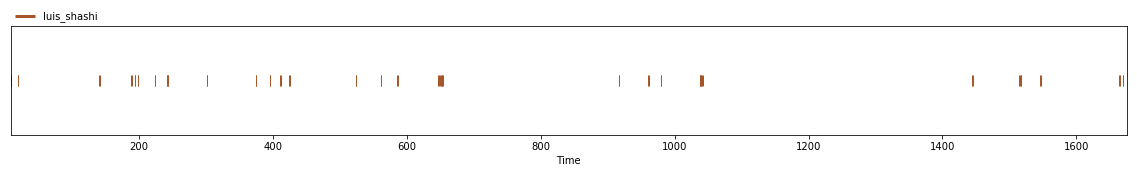

In [29]:
overlap_annotations['luis_shashi']

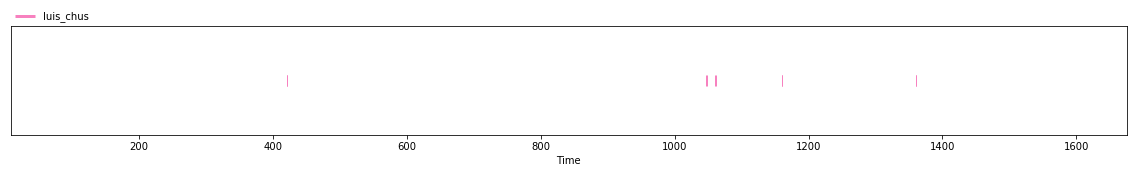

In [30]:
overlap_annotations['luis_chus']

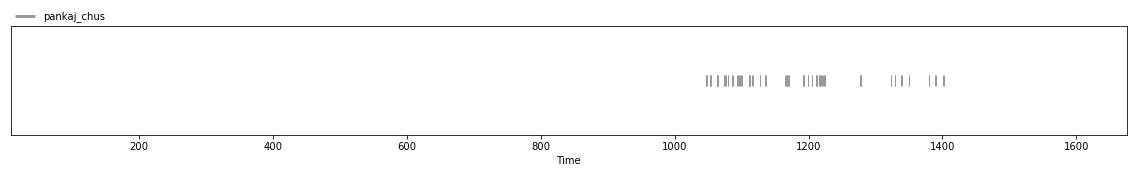

In [31]:
overlap_annotations['pankaj_chus']

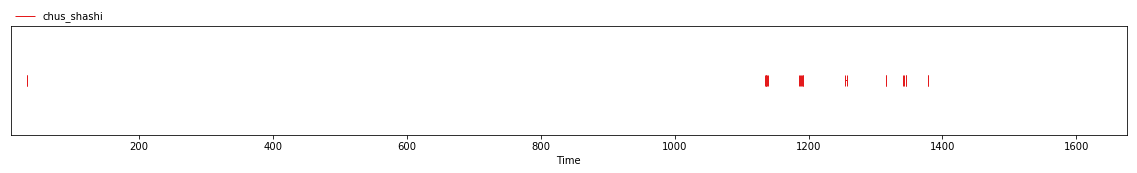

In [32]:
overlap_annotations['chus_shashi']

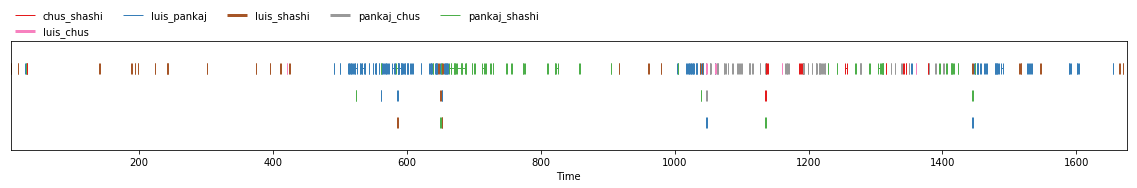

In [33]:
overlap_all

### Network generation
Here, we will generate a network showing who was speaking after whom. The node size will show the speaking time and the edge width will show the frequency of communication between participants of corresponding nodes.

In [59]:
edge_list = generateEdgeList(all_an)

850


In [60]:
total_edges = len(edge_list)

In [70]:
chart = all_an.chart(percent=True)
chart

[('luis', 0.4769481903081484),
 ('shashi', 0.38706671770886186),
 ('pankaj', 0.08380703363678847),
 ('chus', 0.052178058346201275)]

In [64]:
def generateEdgeList(all_an):
    
    df = pd.DataFrame(columns=['start','end','label'])
    for segment, _, label in all_an.itertracks(yield_label=True):
        df = df.append({'start':segment.start,'end':segment.end,'label':label},ignore_index=True)
    df['duration'] = df['end'] - df['start']

    sequence = df['label'].to_list()
    labels = df['label'].unique()

    turn_df = pd.DataFrame(columns=['label','conti_frequency'])

    # This function will count the number of continuous occurence
    def count_conti_occurence(index):

        # Set count to 0
        count=0

        # Starts from the given index
        j = index

        # Loop to iterate over the users sequence
        while j<len(sequence):

            # Increase the count if the element at given index (parameter) is same as the iterated element
            if sequence[j] == sequence[index]:
                count +=1

            # If mismatch found, break the loop
            else:
                break

            # Increases j
            j +=1

        # Return number of count for sequence[index] and index of first next occurence of different element.
        return count,(j-index)

    # Set i to 0 for the Loop
    i = 0

    # Iterate for entire sequence of users
    while i < len(sequence):

        # Call count_conti_occurence() function
        count,diff = count_conti_occurence(i)

        # Add continuous frequency of current user (sequence[i]) to the dataframe
        turn_df = turn_df.append({'label':sequence[i],'conti_frequency':count},ignore_index=True)

        # Move to next different element
        i = i + diff
        
    # Resultant sequence to generate edge file
    processed_sequence = turn_df['label'].to_list()
    
    file  = open('edges.txt','w')

    # Create an empty list
    edge_list = list()

    # Create two variable node1 and node2 and set them to zero.
    node1=node2=0

    print(len(processed_sequence))
    
    # Iterate over resultant users sequences
    for i in range(len(processed_sequence)):       
        # For the first element
        if node1==0:
            # set node1 to the first element
            node1=processed_sequence[i]

        # For rest of the elements
        else:

            # Set the current element to node2
            node2=processed_sequence[i]

            # Append the edge node1, node2 to the edge list
            edge_list.append((node1,node2))

            # Print the edge
            #print("{},{}".format(node1,node2))

            # Write the edge in the file
            file.write("{},{}\n".format(node1,node2))

            # Set the node1 as node2
            node1=node2

    # Close the file
    file.close()

    # Print the message
    #print('Edge file is generate with name edges.txt')
    return edge_list

Graph: [('luis', 'chus'), ('luis', 'pankaj'), ('luis', 'shashi'), ('shashi', 'chus'), ('shashi', 'pankaj'), ('pankaj', 'chus')]


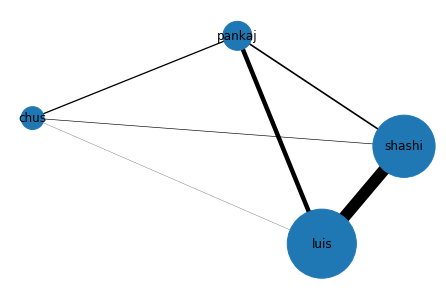

In [98]:
speak_beh = {}
for item in chart:
    speak_beh[item[0]] = item[1]
drawNetwork(edge_list,speak_beh)

In [97]:
def drawNetwork(edge_list,sp_beh):
    # Compute average speaking time
    sp_avg = sum(sp_beh.values())/float(len(sp_beh.values()))

    total_edges = len(edge_list)
    one_edge_size = 10.0/total_edges
    
    # Create an empty graph using networkx library
    G = nx.Graph()

    # Iterate over edge list
    for edge in edge_list:
    # Check if the current edge already exist or not
        if G.has_edge(edge[0],edge[1]):
            # Get the weight of that edge
            w = G[edge[0]][edge[1]]['weight']

            # Remove it from the graph
            G.remove_edge(edge[0],edge[1])

            # Add it again with updated weight
            G.add_edge(edge[0],edge[1],weight=w+2)

        else:

            # If edge doesn't exist in the graph then add it with weight .5
            G.add_edge(edge[0],edge[1],weight=1)

    print('Graph:',G.edges())
    # Layout for showing the network
    pos = nx.spring_layout(G)

    # Get the edges from the graph
    edges = G.edges()

    # Get the weight for every edge
    weights = [G[u][v]['weight']*one_edge_size for u,v in edges]

    # Generate the colormap for the each node on the basis of their speaking time
    color_map = []

    sizes=[]
    labels = []
    
    # iterate for each node in the graph
    for node in G:
        size = sp_beh[node]
        sizes.append( 100 * (size)*100)
        labels.append(node)

  
    # Draw the network
    nx.draw(G, pos,node_size = sizes,width=weights,with_labels=True)
    # Show the network
    plt.tight_layout()
    plt.savefig('phd_meet.png')
    plt.show()

# Feature Extraction for 30 seconds window
This part of the code will extract features from the VAD results. Following features are extracted for each participant
* speaking time
* turn taking
* overlapping time


In [34]:
def verbalFeatures(anno,window_size='30S'):
    chart = anno.chart(percent=True)
    labels = [i[0] for i in chart]
    timelines = {}
    for label in labels:
        timelines[label] = anno.label_timeline(label)   
    df = pd.DataFrame(columns=['start','end','label'])
    for segment, _, label in all_an.itertracks(yield_label=True):
        df = df.append({'start':segment.start,'end':segment.end,'label':label},ignore_index=True)
    df['duration'] = df['end'] - df['start']
    df['start'] = pd.to_datetime(df['start'], unit='s')
    df['end'] = pd.to_datetime(df['end'], unit='s')
    # Setting the index
    df = df.set_index(pd.DatetimeIndex(df['start']))
    
    columns=['frame']
    
    for label in labels:
        col_name = label+'_speak'
        columns.append(col_name)
        
    for label in labels:
        col_name = label+'_turns'
        columns.append(col_name)
    
    final = pd.DataFrame()  
    # End time to stop loop
    end_time = df.iloc[-1,0]
    start_time = df.iloc[0,0]
       
    frame_no = 1
    cur_ts = start_time
    
    # Creating time delta from specified time window
    time_delta = pd.to_timedelta(window_size)
    
    frame_no = 1
    
    while cur_ts < end_time:
        # Computing the end of timewindow
        next_ts = cur_ts + time_delta
        
        #print('Frame:',frame_no)

        # Getting data between two timestamps
        temp_speech_df = df.between_time(datetime.datetime.time(cur_ts),datetime.datetime.time(next_ts),include_start=True,include_end=False)

        # Generate features out of the data
        entry = extractFeatures(frame_no,labels,start_time,cur_ts,temp_speech_df)

        # Adding the entry to the dataframe
        final = final.append(entry,ignore_index=True)

        # Moving starting timestamp to next time window
        cur_ts = next_ts

        frame_no += 1
        
    return final

def extractFeatures(frame,labels,start_time,timestamp,speech_df):  
    speak_time = {}
    for label in labels:
        speak_time[label] = 0
        us = speech_df.loc[speech_df['label']==label,:]
        speak_time[label] = us.duration.sum()

    # String to store the speaking sequence
    speaking_sequence=""

    # Speaking sequence
    sequence = speech_df['label'].tolist()
   
    result = {'frame':frame}   
    for label in labels:
        speak_label = label + '_speak'
        result[speak_label] = speak_time[label]  
    # For computing turn-taking  
    turn_df = pd.DataFrame(columns=['label','conti_frequency'])

    # This function will count the number of continuous occurence
    def count_conti_occurence(index):

        # Set count to 0
        count=0

        # Starts from the given index
        j = index

        # Loop to iterate over the users sequence
        while j<len(sequence):

            # Increase the count if the element at given index (parameter) is same as the iterated element
            if sequence[j] == sequence[index]:
                count +=1

            # If mismatch found, break the loop
            else:
                break

            # Increases j
            j +=1

        # Return number of count for sequence[index] and index of first next occurence of different element.
        return count,(j-index)

    # Set i to 0 for the Loop
    i = 0

    # Iterate for entire sequence of users
    while i < len(sequence):

        # Call count_conti_occurence() function
        count,diff = count_conti_occurence(i)


        # Add continuous frequency of current user (sequence[i]) to the dataframe
        turn_df = turn_df.append({'label':sequence[i],'conti_frequency':count},ignore_index=True)


        # Move to next different element
        i = i + diff
    
    for label in labels:
        turn_label = label + '_turns'
        turns = turn_df.loc[turn_df['label']==label,:]
        
        result[turn_label] = turns.shape[0]
    
    
    
    anno = Annotation()
    for index, record in speech_df.iterrows():      
        start = (record['start'] - start_time).total_seconds()       
        end = (record['end'] - start_time).total_seconds()
        anno[Segment(start, end), '_'] = record['label']
        
    for label1 in labels:
        #print('Label:',label1)
        overlap_label = label1+'_overlap'
        overlap_time = 0
        for label2 in labels:
            if label1 != label2:
                #print('-->',label2)
                label1_timeline = anno.label_timeline(label1)
                label2_timeline = anno.label_timeline(label2)
                
                for seg1,seg2 in label1_timeline.co_iter(label2_timeline):
                    #print('=====>',seg1,seg2,)
                    #print('      ',(seg1 & seg2).duration)
                    overlap_time += (seg1 & seg2).duration
        result[overlap_label] = overlap_time
    
    return result            

In [35]:
f = verbalFeatures(all_an)

In [36]:
f.head()

,chus_overlap,chus_speak,chus_turns,frame,luis_overlap,luis_speak,luis_turns,pankaj_overlap,pankaj_speak,pankaj_turns,shashi_overlap,shashi_speak,shashi_turns
0,0.00,0.00,0.0,1.0,2.34,20.58,4.0,1.53,1.98,1.0,0.81,1.65,3.0
1,0.09,0.75,1.0,2.0,0.00,23.97,1.0,0.00,0.81,1.0,0.09,0.81,1.0
2,0.00,0.00,0.0,3.0,0.00,24.75,1.0,0.00,0.00,0.0,0.00,0.45,1.0
3,0.00,0.00,0.0,4.0,0.00,16.08,2.0,0.00,0.00,0.0,0.00,0.51,1.0
4,0.00,0.00,0.0,5.0,0.99,10.71,2.0,0.00,0.00,0.0,0.99,3.12,1.0


# OpenFace Feature Analysis
The following code analyses the OpenFace features extracted for each participants using OpenFace toolkit.

In [38]:
of = pd.read_csv('Video_11_1.csv')

In [40]:
# Extracting shashi facial features only (because we have ground truth for speaking for that)
shashi_of = of.loc[of.face_id == 0,:]
print('Instance for Shashi:',shashi_of.shape[0])

Instance for Shashi: 75150
